In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

***

In [3]:
sys.path.append('C:\git\statslib')

In [4]:
import statslib as stb

In [5]:
import logging
logger = logging.getLogger()

In [6]:
logger.setLevel(logging.CRITICAL)

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [9]:
import statsmodels.api as sm

In [10]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy

In [11]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [12]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [13]:
figsize=(9*1.6, 9)

In [14]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [15]:
W_TO_CUBIC_METERS = 94.79*1e-6 #https://www.calculat.org/en/energy-fuel/gas-consumption.html

In [16]:
W_TO_CUBIC_METERS = 0.00009090909

# Data

In [17]:
myData = MongoAdapter()

2021-04-24 06:07:35,347: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.


## Gas_view_station_fuel_type_demand

In [18]:
gas = myData.load_stpb_gas_view_power_station_gas_demand(); 
gas.head()

2021-04-24 06:07:35,690: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 36: INFO: Retrieving....


date      value
0 2021-02-28  68.303601
1 2021-02-27  65.235068
2 2021-02-26  61.192432
3 2021-02-25  52.171164
4 2021-02-24  32.815729

In [19]:
gas.columns = ['day', 'gas']
gas.set_index('day', inplace=True)
gas = gas.resample('D').mean()

In [20]:
gas.reset_index(inplace=True)

## Power_view__power_station_fuel_type_demand

In [21]:
df_generation = myData.load_stpb_power_view_power_station_fuel_type_demand(); 
df_generation.shape

2021-04-24 06:07:37,027: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 42: INFO: Retrieving....


(2202, 20)

In [22]:
df_generation.head()

biomass    ccgt    coal  intelec  intew  intfr  intifa2  intirl  intned  \
0        0  331779  601531        0    774  71708        0    1116   47836   
1        0  362299  607829        0   4242  68826        0    3352   45280   
2        0  356612  639099        0   4022  67842        0    2684   48094   
3        0  497864  705281        0    860  70440        0     312   46932   
4        0  354787  609756        0   3630  79800        0    2672   45556   

   intnem  intnsl local_datetime  npshyd  nuclear  ocgt  oil  other     ps  \
0       0       0     2015-02-22   34619   371425     0    0  37275  16184   
1       0       0     2015-02-23   30135   371329     0    0  49217  13048   
2       0       0     2015-02-24   29625   371554     0    0  54187  16842   
3       0       0     2015-02-25   33843   377955     0    0  54636  17250   
4       0       0     2015-02-26   31340   393695     0    0  54169  18480   

   settlementPeriod    wind  
0              1176  180293  
1              1176  281900  
2              1176  270757  
3              1176  114735  
4              1176  245601

In [23]:
ccgt = deepcopy(df_generation.set_index('local_datetime')['ccgt'])

In [24]:
ccgt.describe().to_frame().style.format('{:,.2f}')

In [25]:
ccgt = ccgt.resample('D').mean()

In [26]:
ccgt.index.freq

<Day>

In [27]:
ccgt = ccgt.multiply(W_TO_CUBIC_METERS)

In [28]:
ccgt = ccgt.to_frame()
ccgt.reset_index(inplace=True)

In [29]:
ccgt.columns = ['day', 'ccgt']

In [30]:
ccgt.describe().style.format('{:,.2f}')

## Weather covariates

2021-04-24 06:07:40,324: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 96: INFO: Retrieving....


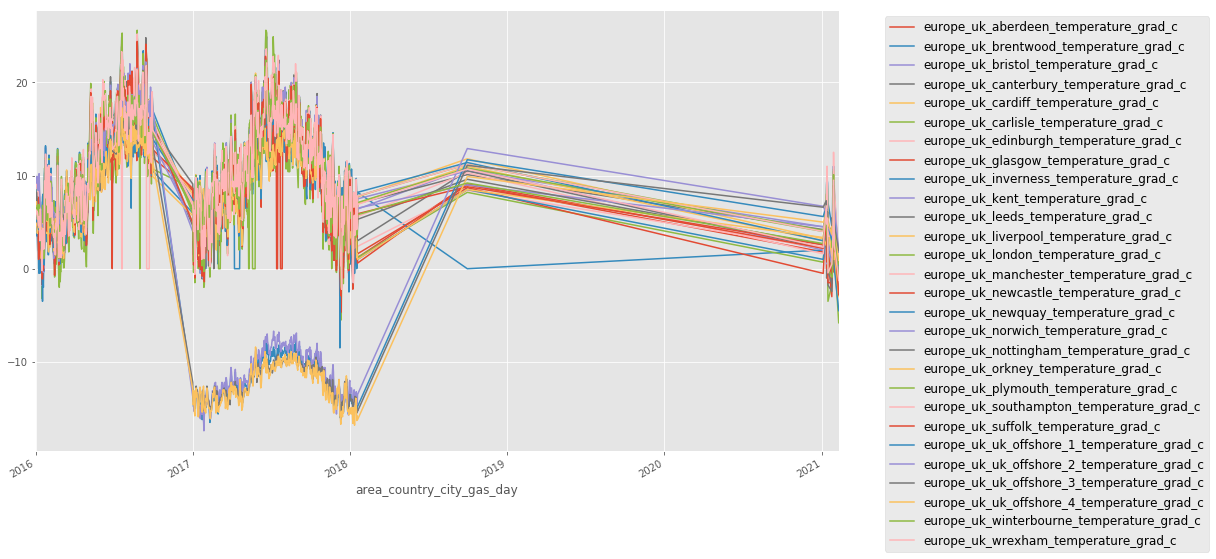

In [31]:
temp = myData.load_covariates_temperature()
myData.plot_weather(temp)

In [32]:
dt_range_len = len(pd.date_range(start=date(2015,12,31), 
                                 end=ccgt.day.max().date()
                                ));
dt_range_len

cols = temp.columns

res = []
for col in cols:
    _df = temp[col].dropna()
    res.append([col, _df.shape[0],dt_range_len-_df.shape[0], _df.index.min(), _df.index.max()])

summary = pd.DataFrame(res);
summary.columns=['name', 'count', 'missing', 'min', 'max']
summary.sort_values(by=['count'], inplace=True, ascending=False)

summary

name  count  missing        min  \
14      europe_uk_newcastle_temperature_grad_c   1878       12 2015-12-31   
6       europe_uk_edinburgh_temperature_grad_c   1878       12 2015-12-31   
7         europe_uk_glasgow_temperature_grad_c   1878       12 2015-12-31   
13     europe_uk_manchester_temperature_grad_c   1877       13 2015-12-31   
20    europe_uk_southampton_temperature_grad_c   1875       15 2015-12-31   
3      europe_uk_canterbury_temperature_grad_c   1874       16 2015-12-31   
15        europe_uk_newquay_temperature_grad_c   1873       17 2015-12-31   
26   europe_uk_winterbourne_temperature_grad_c   1873       17 2015-12-31   
5        europe_uk_carlisle_temperature_grad_c   1873       17 2015-12-31   
17     europe_uk_nottingham_temperature_grad_c   1873       17 2015-12-31   
19       europe_uk_plymouth_temperature_grad_c   1868       22 2015-12-31   
21        europe_uk_suffolk_temperature_grad_c   1860       30 2015-12-31   
18         europe_uk_orkney_temperature_grad_c   1860       30 2015-12-31   
16        europe_uk_norwich_temperature_grad_c   1860       30 2015-12-31   
0        europe_uk_aberdeen_temperature_grad_c   1860       30 2015-12-31   
12         europe_uk_london_temperature_grad_c   1860       30 2015-12-31   
10          europe_uk_leeds_temperature_grad_c   1860       30 2015-12-31   
8       europe_uk_inverness_temperature_grad_c   1860       30 2015-12-31   
27        europe_uk_wrexham_temperature_grad_c   1860       30 2015-12-31   
11      europe_uk_liverpool_temperature_grad_c   1859       31 2015-12-31   
4         europe_uk_cardiff_temperature_grad_c   1852       38 2015-12-31   
9            europe_uk_kent_temperature_grad_c   1842       48 2015-12-31   
22  europe_uk_uk_offshore_1_temperature_grad_c   1612      278 2015-12-31   
23  europe_uk_uk_offshore_2_temperature_grad_c   1610      280 2015-12-31   
24  europe_uk_uk_offshore_3_temperature_grad_c   1610      280 2015-12-31   
25  europe_uk_uk_offshore_4_temperature_grad_c   1610      280 2015-12-31   
2         europe_uk_bristol_temperature_grad_c   1059      831 2015-12-31   
1       europe_uk_brentwood_temperature_grad_c   1028      862 2015-12-31   

          max  
14 2021-02-20  
6  2021-02-20  
7  2021-02-20  
13 2021-02-20  
20 2021-02-17  
3  2021-02-15  
15 2021-02-14  
26 2021-02-14  
5  2021-02-14  
17 2021-02-14  
19 2021-02-14  
21 2021-02-20  
18 2021-02-20  
16 2021-02-20  
0  2021-02-20  
12 2021-02-20  
10 2021-02-20  
8  2021-02-20  
27 2021-02-20  
11 2021-02-20  
4  2021-02-14  
9  2021-02-20  
22 2021-02-16  
23 2021-02-16  
24 2021-02-16  
25 2021-02-16  
2  2021-02-20  
1  2021-02-09

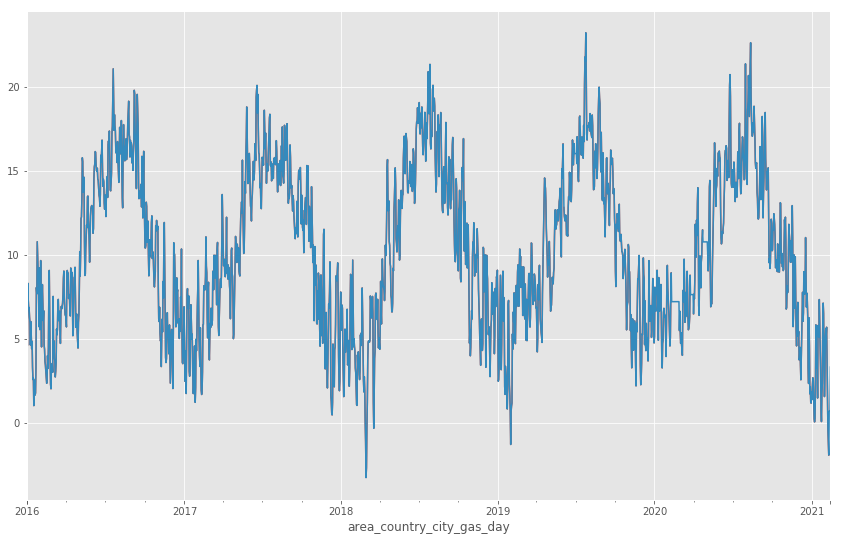

In [33]:
temp_filtered = summary.where(summary.missing<50).dropna()['name'].values

avg_temp = temp[temp_filtered].dropna(axis=0).resample('D').mean().mean(axis=1);
avg_temp.plot(figsize=figsize)

avg_temp_d = avg_temp.resample('D').mean()

avg_temp_dfill = pd.concat([avg_temp_d.ffill(), avg_temp_d.bfill()]).groupby(level=0).mean()

avg_temp_dfill.plot(figsize=figsize)

In [34]:
avg_temp_dfill = avg_temp_dfill.to_frame()
avg_temp_dfill.reset_index(inplace=True)
avg_temp_dfill.columns = ['day', 'temperature']

***

2021-04-24 06:07:43,644: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 103: INFO: Retrieving....


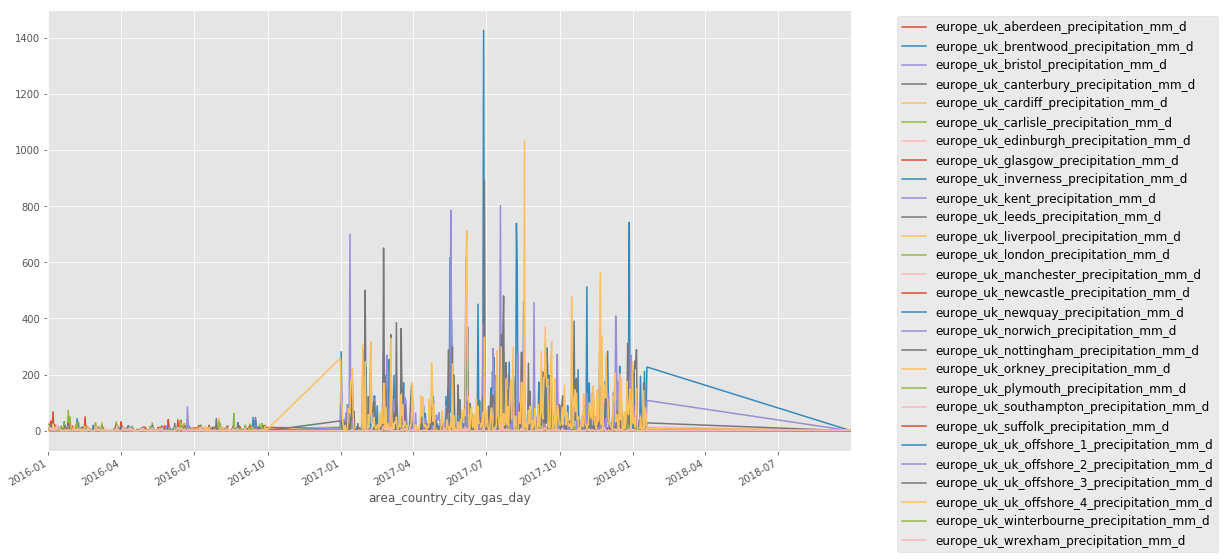

In [35]:
precip = myData.load_covariates_preciptation()
myData.plot_weather(precip)

In [36]:
import statsmodels.api as sm

In [37]:
sm.__version__

'0.12.2'

In [38]:
dt_range_len = len(pd.date_range(start=date(2015,12,31), 
                                 end=ccgt.day.max().date()
                                ));
dt_range_len

cols = precip.columns

res = []
for col in cols:
    _df = precip[col].dropna()
    res.append([col, _df.shape[0],dt_range_len-_df.shape[0], _df.index.min(), _df.index.max()])

summary = pd.DataFrame(res);
summary.columns=['name', 'count', 'missing', 'min', 'max']
summary.sort_values(by=['count'], inplace=True, ascending=False)

summary

name  count  missing        min  \
15        europe_uk_newquay_precipitation_mm_d   1870       20 2015-12-31   
3      europe_uk_canterbury_precipitation_mm_d   1866       24 2015-12-31   
26   europe_uk_winterbourne_precipitation_mm_d   1865       25 2015-12-31   
17     europe_uk_nottingham_precipitation_mm_d   1865       25 2015-12-31   
4         europe_uk_cardiff_precipitation_mm_d   1864       26 2015-12-31   
6       europe_uk_edinburgh_precipitation_mm_d   1864       26 2015-12-31   
21        europe_uk_suffolk_precipitation_mm_d   1863       27 2015-12-31   
13     europe_uk_manchester_precipitation_mm_d   1862       28 2015-12-31   
12         europe_uk_london_precipitation_mm_d   1861       29 2015-12-31   
14      europe_uk_newcastle_precipitation_mm_d   1860       30 2015-12-31   
7         europe_uk_glasgow_precipitation_mm_d   1859       31 2015-12-31   
5        europe_uk_carlisle_precipitation_mm_d   1857       33 2015-12-31   
27        europe_uk_wrexham_precipitation_mm_d   1852       38 2015-12-31   
18         europe_uk_orkney_precipitation_mm_d   1851       39 2015-12-31   
19       europe_uk_plymouth_precipitation_mm_d   1848       42 2015-12-31   
0        europe_uk_aberdeen_precipitation_mm_d   1832       58 2015-12-31   
22  europe_uk_uk_offshore_1_precipitation_mm_d   1612      278 2015-12-31   
23  europe_uk_uk_offshore_2_precipitation_mm_d   1610      280 2015-12-31   
24  europe_uk_uk_offshore_3_precipitation_mm_d   1610      280 2015-12-31   
25  europe_uk_uk_offshore_4_precipitation_mm_d   1610      280 2015-12-31   
10          europe_uk_leeds_precipitation_mm_d   1447      443 2015-12-31   
8       europe_uk_inverness_precipitation_mm_d   1062      828 2015-12-31   
2         europe_uk_bristol_precipitation_mm_d   1060      830 2015-12-31   
11      europe_uk_liverpool_precipitation_mm_d   1058      832 2015-12-31   
16        europe_uk_norwich_precipitation_mm_d   1051      839 2015-12-31   
9            europe_uk_kent_precipitation_mm_d   1049      841 2015-12-31   
20    europe_uk_southampton_precipitation_mm_d   1042      848 2015-12-31   
1       europe_uk_brentwood_precipitation_mm_d   1026      864 2015-12-31   

          max  
15 2021-02-14  
3  2021-02-17  
26 2021-02-14  
17 2021-02-14  
4  2021-02-14  
6  2021-02-14  
21 2021-02-14  
13 2021-02-14  
12 2021-02-14  
14 2021-02-14  
7  2021-02-14  
5  2021-02-14  
27 2021-02-14  
18 2021-02-14  
19 2021-02-14  
0  2021-02-14  
22 2021-02-16  
23 2021-02-16  
24 2021-02-16  
25 2021-02-16  
10 2021-02-14  
8  2021-02-10  
2  2021-02-14  
11 2021-02-14  
16 2021-02-14  
9  2021-02-14  
20 2021-02-14  
1  2021-02-12

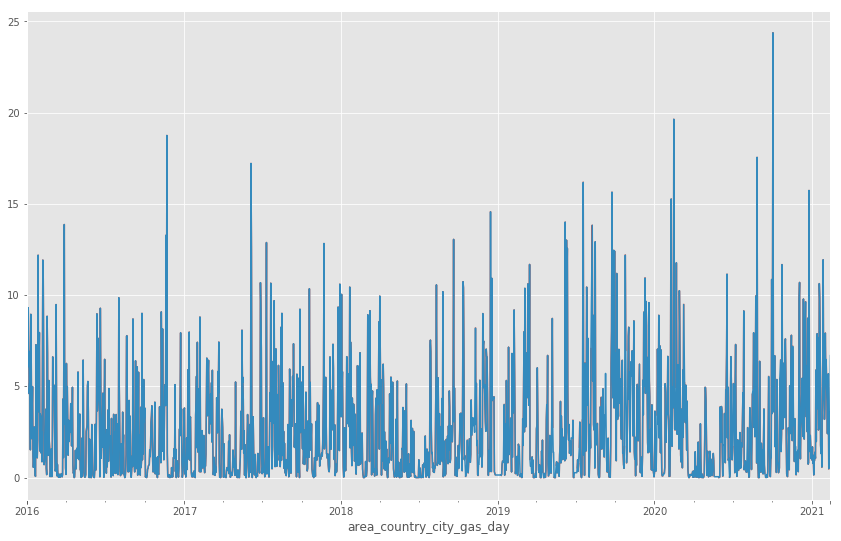

In [39]:
precip_filtered = summary.where(summary.missing<50).dropna()['name'].values

avg_precip = precip[precip_filtered].dropna(axis=0).resample('D').mean().mean(axis=1);
avg_precip.plot(figsize=figsize)

avg_precip_d = avg_precip.resample('D').mean()

avg_precip_dfill = pd.concat([avg_precip_d.ffill(), avg_precip_d.bfill()]).groupby(level=0).mean()

avg_precip_dfill.plot(figsize=figsize)

In [40]:
avg_precip_dfill = avg_precip_dfill.to_frame()
avg_precip_dfill.reset_index(inplace=True)
avg_precip_dfill.columns = ['day', 'precip']

***

2021-04-24 06:07:47,732: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 110: INFO: Retrieving....


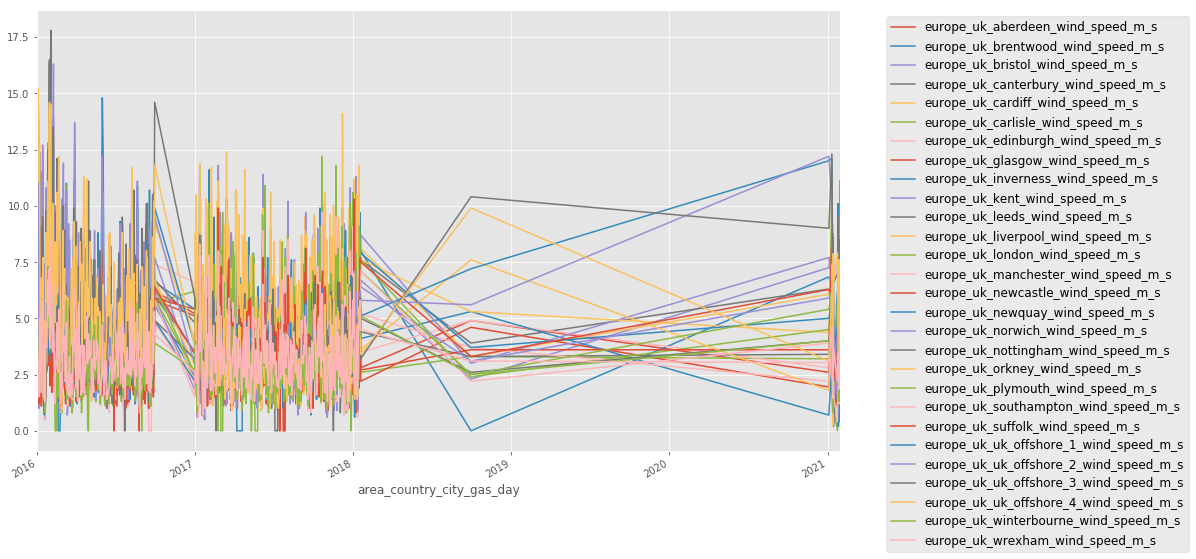

In [41]:
wind = myData.load_covariates_wind()
myData.plot_weather(wind)

In [42]:
dt_range_len = len(pd.date_range(start=date(2015,12,31), 
                                 end=ccgt.day.max().date()
                                ));
dt_range_len

cols = wind.columns

res = []
for col in cols:
    _df = wind[col].dropna()
    res.append([col, _df.shape[0],dt_range_len-_df.shape[0], _df.index.min(), _df.index.max()])

summary = pd.DataFrame(res);
summary.columns=['name', 'count', 'missing', 'min', 'max']
summary.sort_values(by=['count'], inplace=True, ascending=False)

summary

name  count  missing        min  \
14      europe_uk_newcastle_wind_speed_m_s   1878       12 2015-12-31   
13     europe_uk_manchester_wind_speed_m_s   1878       12 2015-12-31   
6       europe_uk_edinburgh_wind_speed_m_s   1878       12 2015-12-31   
7         europe_uk_glasgow_wind_speed_m_s   1878       12 2015-12-31   
3      europe_uk_canterbury_wind_speed_m_s   1876       14 2015-12-31   
20    europe_uk_southampton_wind_speed_m_s   1876       14 2015-12-31   
26   europe_uk_winterbourne_wind_speed_m_s   1873       17 2015-12-31   
17     europe_uk_nottingham_wind_speed_m_s   1873       17 2015-12-31   
15        europe_uk_newquay_wind_speed_m_s   1873       17 2015-12-31   
5        europe_uk_carlisle_wind_speed_m_s   1869       21 2015-12-31   
21        europe_uk_suffolk_wind_speed_m_s   1859       31 2015-12-31   
18         europe_uk_orkney_wind_speed_m_s   1859       31 2015-12-31   
16        europe_uk_norwich_wind_speed_m_s   1859       31 2015-12-31   
0        europe_uk_aberdeen_wind_speed_m_s   1859       31 2015-12-31   
12         europe_uk_london_wind_speed_m_s   1859       31 2015-12-31   
11      europe_uk_liverpool_wind_speed_m_s   1859       31 2015-12-31   
10          europe_uk_leeds_wind_speed_m_s   1859       31 2015-12-31   
8       europe_uk_inverness_wind_speed_m_s   1859       31 2015-12-31   
27        europe_uk_wrexham_wind_speed_m_s   1859       31 2015-12-31   
4         europe_uk_cardiff_wind_speed_m_s   1853       37 2015-12-31   
9            europe_uk_kent_wind_speed_m_s   1851       39 2015-12-31   
19       europe_uk_plymouth_wind_speed_m_s   1821       69 2015-12-31   
22  europe_uk_uk_offshore_1_wind_speed_m_s   1612      278 2015-12-31   
23  europe_uk_uk_offshore_2_wind_speed_m_s   1610      280 2015-12-31   
24  europe_uk_uk_offshore_3_wind_speed_m_s   1610      280 2015-12-31   
25  europe_uk_uk_offshore_4_wind_speed_m_s   1610      280 2015-12-31   
2         europe_uk_bristol_wind_speed_m_s   1059      831 2015-12-31   
1       europe_uk_brentwood_wind_speed_m_s   1024      866 2015-12-31   

          max  
14 2021-02-20  
13 2021-02-20  
6  2021-02-20  
7  2021-02-20  
3  2021-02-17  
20 2021-02-17  
26 2021-02-14  
17 2021-02-14  
15 2021-02-14  
5  2021-02-14  
21 2021-02-20  
18 2021-02-20  
16 2021-02-20  
0  2021-02-20  
12 2021-02-20  
11 2021-02-20  
10 2021-02-20  
8  2021-02-20  
27 2021-02-20  
4  2021-02-14  
9  2021-02-20  
19 2021-02-14  
22 2021-02-16  
23 2021-02-16  
24 2021-02-16  
25 2021-02-16  
2  2021-02-20  
1  2021-02-04

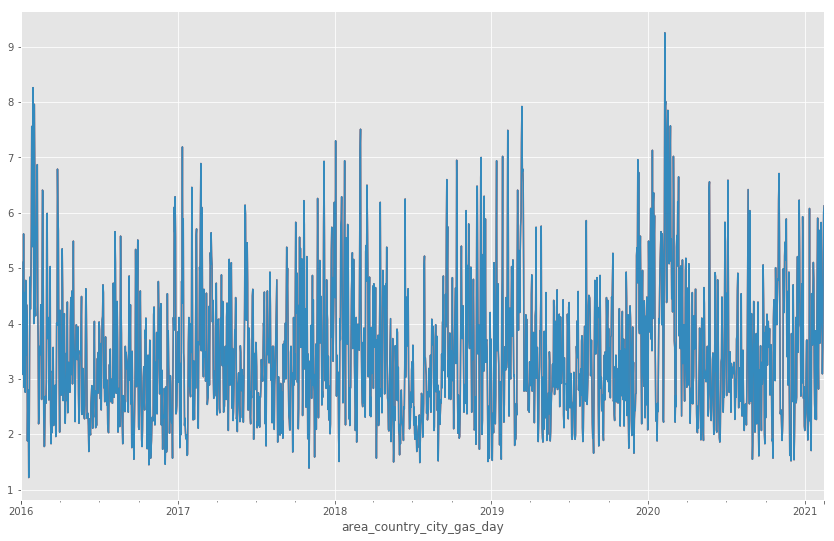

In [43]:
wind_filtered = summary.where(summary.missing<31).dropna()['name'].values

avg_wind = wind[wind_filtered].dropna(axis=0).resample('D').mean().mean(axis=1);
avg_wind.plot(figsize=figsize)

avg_wind_d = avg_wind.resample('D').mean()

avg_wind_dfill = pd.concat([avg_wind_d.ffill(), avg_wind_d.bfill()]).groupby(level=0).mean()

avg_wind_dfill.plot(figsize=figsize)

In [44]:
avg_wind_dfill = avg_wind_dfill.to_frame()
avg_wind_dfill.reset_index(inplace=True)
avg_wind_dfill.columns = ['day', 'wind']

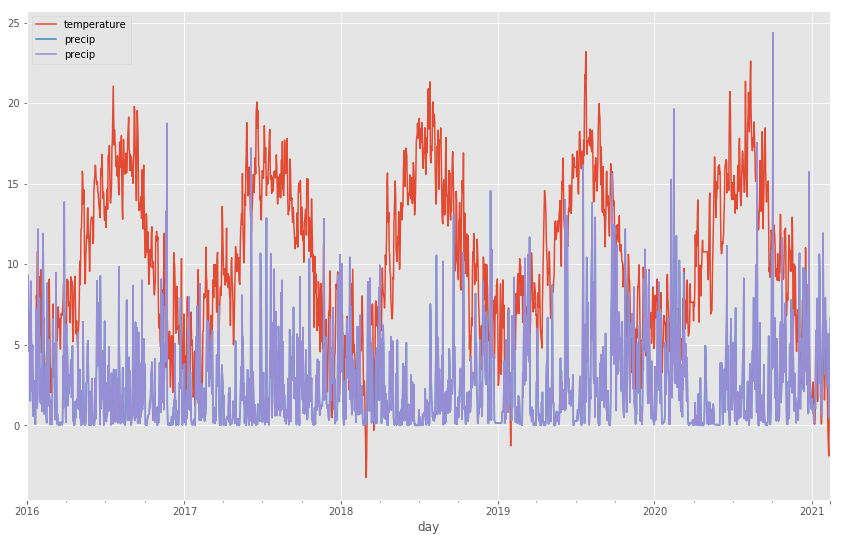

In [45]:
stb.utils.dframe.concat_columnwise(
    avg_temp_dfill.set_index('day'), 
    avg_precip_dfill.set_index('day'),
    avg_precip_dfill.set_index('day')).plot(figsize=figsize)

# Spread Covariates

2021-04-24 06:07:52,365: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 89: INFO: Retrieving....


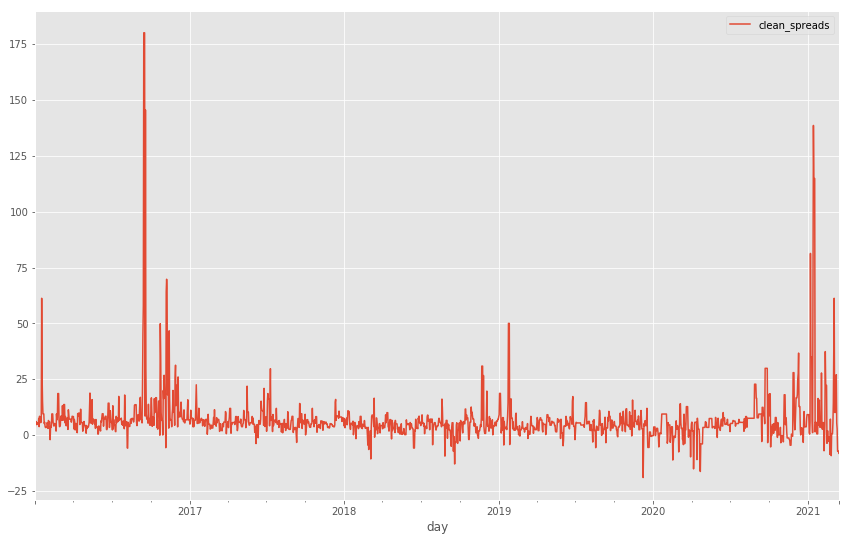

In [46]:
clean_spreads = myData.load_covariates_clean_spread()

clean_spreads = clean_spreads.reset_index()

clean_spreads.columns=['day', 'clean_spreads']

clean_spreads.set_index('day', inplace=True)

null_idx = clean_spreads[(clean_spreads==0).any(axis=1)].index

clean_spreads.loc[null_idx] = np.NaN

stb.utils.dframe.concat_columnwise(clean_spreads.fillna(method='ffill'),clean_spreads,pd.Series(clean_spreads.index.weekday, index=clean_spreads.index)).head(10)

clean_spreads = clean_spreads.fillna(method='ffill')

clean_spreads.plot(figsize=figsize)

clean_spreads.reset_index(inplace=True)

***

2021-04-24 06:07:53,293: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 82: INFO: Retrieving....


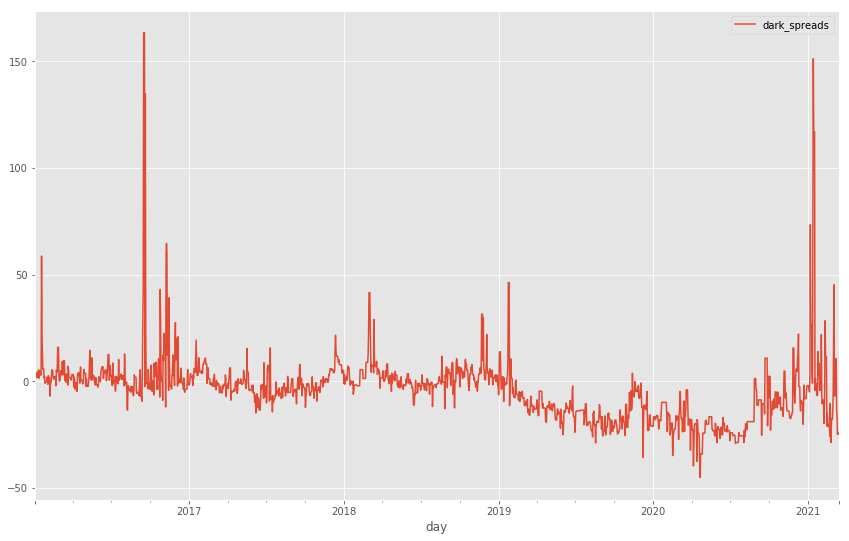

In [47]:
dark_spreads = myData.load_covariates_dark_spread()
dark_spreads = dark_spreads.reset_index()
dark_spreads.columns=['day', 'dark_spreads']
dark_spreads.set_index('day', inplace=True)
null_idx = dark_spreads[(dark_spreads==0).any(axis=1)].index
dark_spreads.loc[null_idx] = np.NaN
stb.utils.dframe.concat_columnwise(dark_spreads.fillna(method='ffill'),dark_spreads,pd.Series(dark_spreads.index.weekday, index=dark_spreads.index)).head(10)
dark_spreads = dark_spreads.fillna(method='ffill')
dark_spreads.plot(figsize=figsize)
dark_spreads.reset_index(inplace=True)

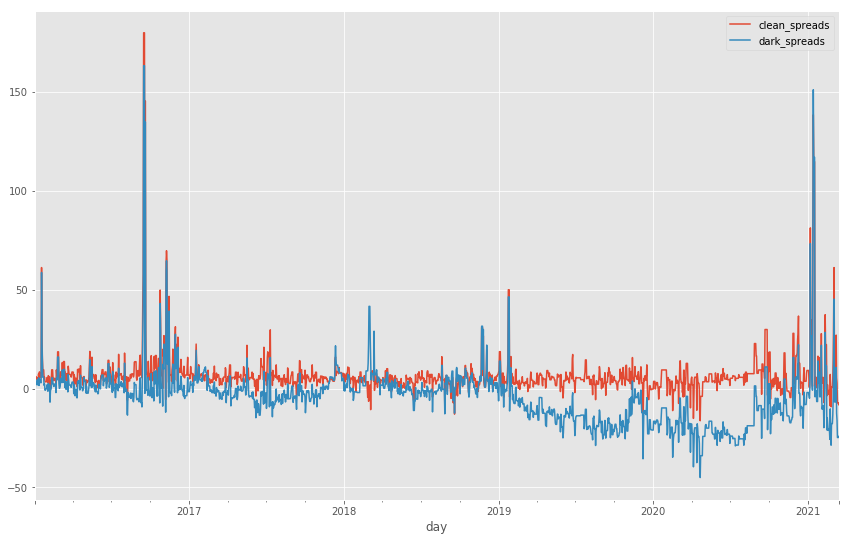

In [48]:
stb.utils.dframe.concat_columnwise(clean_spreads.set_index('day'), dark_spreads.set_index('day')).plot(figsize=figsize)

# Short Term Curves

In [49]:
# short term curves
curves = [
    103234271,
    103234272,
    103234276,
    103234278,
    103234281]

In [50]:
myData = MongoAdapter()
hist_fct = myData.load_stpb_historical_forecasts(); 

2021-04-24 06:07:55,576: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-24 06:07:55,636: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 48: INFO: Retrieving....


In [51]:
hist_fct.head()

effective_date_with_time    value
curve_id  effective_date point_date                                  
103234271 2015-07-29     2015-07-31      2015-07-29 13:23:00  21678.0
                         2015-07-31      2015-07-29 13:34:00  21678.0
                         2015-08-01      2015-07-29 13:23:00  20944.0
                         2015-08-01      2015-07-29 13:34:00  20944.0
                         2015-08-02      2015-07-29 13:23:00  20987.0

In [52]:
hist_fct = hist_fct.loc[curves]

In [53]:
hist_fct = hist_fct.reset_index().set_index(['curve_id', 'effective_date']
                          ).drop_duplicates(subset=[
    'point_date','value'],keep='last').reset_index(
).set_index(['curve_id', 'effective_date', 'point_date'])

In [54]:
hist_fct = hist_fct['value']

In [55]:
hist_fct = pd.concat([hist_fct.loc[curve].groupby(level=1).last().rename(curve) for curve in curves], axis=1)
    

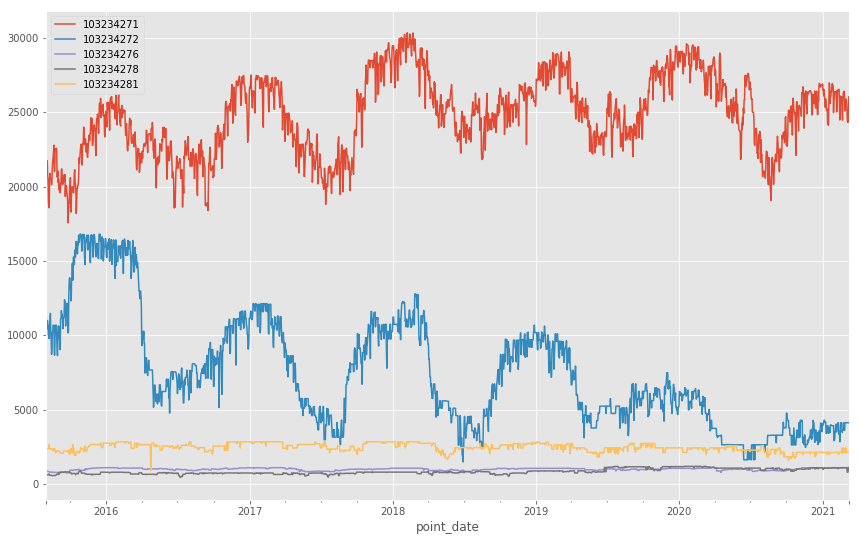

In [56]:
hist_fct.plot(figsize=figsize)

In [57]:
hist_fct = hist_fct.mul(W_TO_CUBIC_METERS*10)

In [58]:
crvs = [103234276,
103234278,
103234281]

In [59]:
for c in crvs:
    hist_fct[c] = hist_fct[c].mul(10)

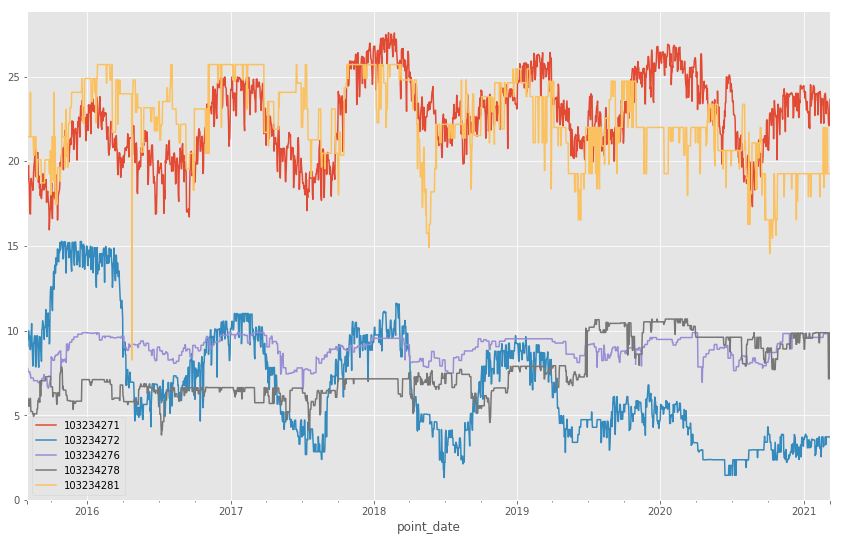

In [60]:
hist_fct.plot(figsize=figsize)

In [61]:
hist_fct.index.name = 'day'

In [62]:
hist_fct.columns = [f'curve_{c}' for c in hist_fct.columns]

In [63]:
hist_fct.columns

Index(['curve_103234271', 'curve_103234272', 'curve_103234276',
       'curve_103234278', 'curve_103234281'],
      dtype='object')

In [67]:
hist_fct = hist_fct.fillna(method='ffill')

In [68]:
stb.utils.dframe.df_see_null_na_values(hist_fct)

Displaying up to 2 #N/A rows. Please use returned NA index.

isnull:


Empty DataFrame
Columns: [curve_103234271, curve_103234272, curve_103234276, curve_103234278, curve_103234281]
Index: []


isna:


Empty DataFrame
Columns: [curve_103234271, curve_103234272, curve_103234276, curve_103234278, curve_103234281]
Index: []

DatetimeIndex([], dtype='datetime64[ns]', name='day', freq=None)

In [69]:
hist_fct.reset_index(inplace=True)

# DESIGN MATRIX TO MONGO

In [70]:
dataDM = pd.concat([
                hist_fct.set_index('day'),
                gas.set_index('day'),
                dark_spreads.set_index('day'),
                clean_spreads.set_index('day'),
                avg_temp_dfill.set_index('day'),
                avg_wind_dfill.set_index('day'), 
                avg_precip_dfill.set_index('day'),

], axis=1).dropna()

In [71]:
dataDM.head()

curve_103234271  curve_103234272  curve_103234276  \
day                                                             
2016-01-03        21.827273        13.840909         9.872727   
2016-01-04        23.332727        14.581818         9.872727   
2016-01-05        22.972727        14.581818         9.872727   
2016-01-06        22.884545        14.781818         9.872727   
2016-01-07        23.320000        14.354545         9.872727   

            curve_103234278  curve_103234281        gas  dark_spreads  \
day                                                                     
2016-01-03         7.118182        24.890909  42.628297     -0.044293   
2016-01-04         7.118182        24.890909  54.325737      2.582538   
2016-01-05         7.118182        24.890909  60.625773      2.552673   
2016-01-06         7.118182        24.890909  61.146998      2.064360   
2016-01-07         6.954545        24.890909  54.514549      4.277249   

            clean_spreads  temperature  wind    precip  
day                                                     
2016-01-03       3.778045     7.327273  4.52  9.306667  
2016-01-04       6.196248     6.845455  4.20  7.133333  
2016-01-05       5.929635     6.868182  3.52  6.080000  
2016-01-06       4.766417     6.309091  3.08  6.906667  
2016-01-07       5.395240     5.981818  5.62  4.786667

In [72]:
myData = MongoAdapter()

myData.mongo.choose_db(myData.GAS_MODELS_DB)

collection = myData.STPB_DESIGN_MATRIX
if collection not in myData.mongo.db.list_collection_names():
    myData.mongo.db.create_collection(name=collection)
    myData.mongo.choose_collection(collection)
else:
    myData.mongo.choose_collection(collection)
    myData.mongo.clear_collection()

time.sleep(5) #<---we need time to clean MongoDB collections

myData.mongo.pandas_to_mongo(dataDM.reset_index())

myData = MongoAdapter()
dataDM = myData.load_design_matrix()

2021-04-24 06:10:14,866: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-24 06:10:20,199: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 100: DEBUG: Saving 1870 rows to MongoDb.
2021-04-24 06:10:21,332: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\data_sources\mongo.py: 25: DEBUG: Connected successfully.
2021-04-24 06:10:21,387: c:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\stpb\stpb.py: 75: INFO: Retrieving....


In [73]:
dataDM.shape

(1870, 11)